In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from tqdm import tqdm

In [2]:
import torch.version


# print(torch.version.cuda)
print(torch.cuda.is_available())

True


In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2, T = 100):
        """
        input_dim: dimension of input (x and t concatenated)
        output_dim: dimension of output (drift term)
        """
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.time_emb = nn.Embedding(T, 32)
    
    def forward(self, x, t):
        """
        x: Tensor of shape (batch_size, 2)
        t: Tensor of shape (batch_size, 1)
        """
        # Concatenate x and t
        # print(x.shape, self.time_emb(t).shape)
        xt = torch.cat([x, self.time_emb(t)], dim=-1)  # Shape: (batch_size, 3)
        return self.net(xt)

In [4]:
class SchrödingerBridgeDataset(Dataset):
    def __init__(self, initial_samples: int, final_samples: int):
        """
        Args:
            initial_samples (int): Number of samples from the initial distribution.
            final_samples (int): Number of samples from the final distribution.
        """
        super(SchrödingerBridgeDataset, self).__init__()
        
        self.initial_data = self.uniform_distribution(final_samples)
        # self.final_data = self.uniform_distribution(initial_samples) + 2
        self.final_data = self.bimodal_distribution(final_samples)
        random_index = torch.randperm(len(self.final_data))
        self.final_data = self.final_data[random_index, :]
    @staticmethod
    def uniform_distribution(batch_size: int) -> torch.Tensor:
        """
        Uniform distribution in [-1, 1] x [-1, 1].
        """
        return torch.rand(batch_size, 1) * 2 - 1  # Shape: (batch_size, 2)
    
    @staticmethod
    def bimodal_distribution(batch_size: int) -> torch.Tensor:
        """
        Bimodal distribution with two Gaussian clusters.
        """
        half = batch_size // 2
        cluster1 = torch.randn(half, 1) + 2.0  # Cluster centered at (2)
        cluster2 = torch.randn(batch_size - half, 1) - 2.0  # Cluster centered at (-2)
        return torch.cat([cluster1, cluster2], dim=0)  # Shape: (batch_size, 1)
    
    def __len__(self):
        # Total samples are from both initial and final distributions
        return max(len(self.initial_data), len(self.final_data))
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of (x_initial, x_final).
        If one distribution has fewer samples, wrap around using modulo.
        """
        x_initial = self.initial_data[idx % len(self.initial_data)]
        x_final = self.final_data[idx % len(self.final_data)]
        return {"x0": x_initial, "xT":x_final}
    def plot(self):
        bins = np.linspace(-5, 5, 100)
        plt.hist(self.initial_data.detach().numpy(), bins = bins, alpha = 0.3, label = "inital_distribution")
        plt.hist(self.final_data.detach().numpy(), bins = bins, alpha = 0.3, label = "final_distribution")
        plt.legend()
        plt.grid()
        plt.show()
        

In [5]:
ds = SchrödingerBridgeDataset(10000, 10000)

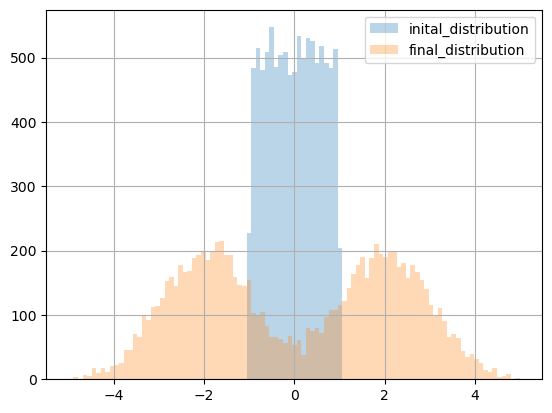

In [6]:
# print(ds[0])
ds.plot()

In [26]:
def lagevin(x:torch.Tensor, model:nn.Module, t:torch.IntTensor, T:int, gamma:torch.Tensor):
    traj_x = [x.unsqueeze(-1)]
    for i in range(0, T):
        time = torch.full((x.shape[0], 1), fill_value = i)
        # x = x + gamma*model(x, time) + torch.sqrt(2*gamma)*torch.rand_like(x)
        x = x + model(x, time) + torch.sqrt(2*gamma)*torch.rand_like(x)
        traj_x.append(x.unsqueeze(-1))
    all_x = torch.cat(traj_x, dim = -1)
    return torch.gather(all_x, dim = -1, index = t)
        

In [27]:
def first_process(x0, xT, T, sigma, inverse = False):
    x_all = torch.zeros((x0.shape[0], x0.shape[1], T+1))
    grad_all = torch.zeros((x0.shape[0], x0.shape[1], T))
    x_all[:,:,0] = x0
    for i in range(1,T+1):
        mu_i = (xT - x0)*i/T
        x_all[:, :, i] = x0 + mu_i + torch.sqrt(2*sigma[i-1])*torch.randn_like(x0)
        grad_all[:,:,i-1] = x_all[:,:,i] - x_all[:,:,i-1] if not inverse else -x_all[:,:,i] + x_all[:,:,i-1]
    return x_all, grad_all

In [28]:
print(ds.final_data.shape)

torch.Size([10000, 1])


In [29]:
x_all, grad_all = first_process(ds.final_data, ds.initial_data, T = 50, sigma=1e-2*torch.ones((len(ds.final_data)))*1)

In [30]:
# # print(grad_all.shape)
# plt.hist(ds.final_data)

(array([   7.,  201., 1255., 2113., 1248.,  770., 1747., 1897.,  694.,
          68.]),
 array([-5.87843227, -4.76162004, -3.64480734, -2.52799511, -1.41118264,
        -0.29437017,  0.82244223,  1.93925464,  3.05606699,  4.1728797 ,
         5.28969193]),
 <BarContainer object of 10 artists>)

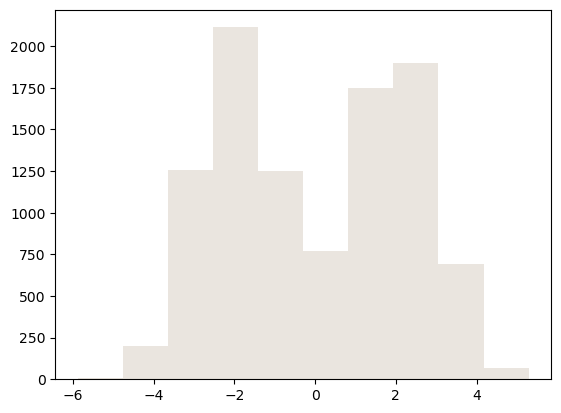

In [31]:
plt.hist(ds.final_data.numpy(), alpha = 0.1)
plt.hist(x_all[:, 0,0], alpha = 0.1)

In [32]:
print(x_all.numpy()[:, 0, 0].max())

5.289692


In [33]:
print(x_all.numpy()[-50:, 0, 0])

[ 1.5781333  -2.9751348  -1.6862195   1.4420817  -0.7123928  -2.494922
 -0.27093458 -1.571666    0.08832574  2.1195154  -2.763861    1.9659656
 -2.4143722  -3.1484575  -2.9626455  -1.829951    0.9683577  -1.8652294
 -1.6007534  -2.4768188  -1.1397008  -1.7516373   2.3468077   0.10752988
 -1.6540537   1.4426218   1.3010741   3.3537629  -2.986014    1.9126897
  3.3785338  -2.8621964  -3.234931    2.9028795  -2.713852    2.5476906
  1.1268198  -2.4387267  -3.430235   -2.975462    2.6251109  -2.1029766
 -2.4261746   1.0349727  -1.0307648   2.4280999   2.3073785   1.8493782
  2.5235038  -1.436183  ]


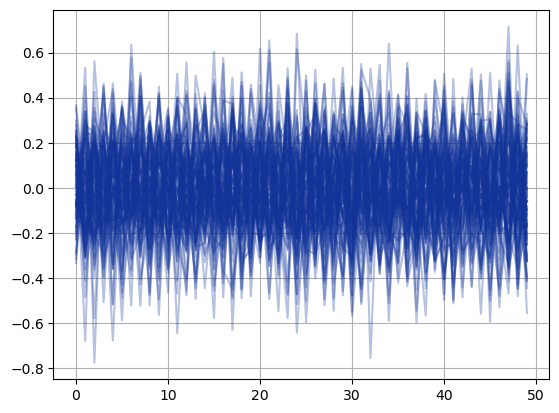

In [34]:
# print(x_all.shape)
# bins = np.linspace(-5, 5, 100)
for i in range(0, 100):
    # i = np.random.randint(0, 1000)
    plt.plot(grad_all.numpy()[i, 0, :], alpha = 0.3, color = "#123499")
plt.grid()
plt.show()

In [35]:
def simple_dsb(dataset, batch_size, epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size)
    pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
    total_loss_f = []
    total_loss_b = []
    f_model.train()
    b_model.eval()
    for inner_epoch in pbar:
        epoch_loss_b = 0
        for data in dl:
            x0, xT = data['x0'].to(device), data["xT"].to(device)
            x_all, grad_all = first_process(x0, xT, T = T, sigma=sigma)
            x_all = x_all[..., :-1]
            sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1))
            sample_xk = torch.gather(x_all, dim = -1, index = sample_t)
            grad_out = torch.gather(grad_all, dim = -1, index = sample_t)
            pred_out = f_model(sample_xk, sample_t.squeeze(-1))
            f_optim.zero_grad()
            loss_b = nn.functional.mse_loss(input = pred_out, target= grad_out)
            loss_b.backward()
            torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
            f_optim.step()
            epoch_loss_b += loss_b.item()
        pbar.set_postfix({"forward_loss": epoch_loss_b/len(dl)})
        total_loss_b.append(epoch_loss_b/len(dl))
    plt.plot(total_loss_b)
    plt.show()
    return f_model, b_model

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

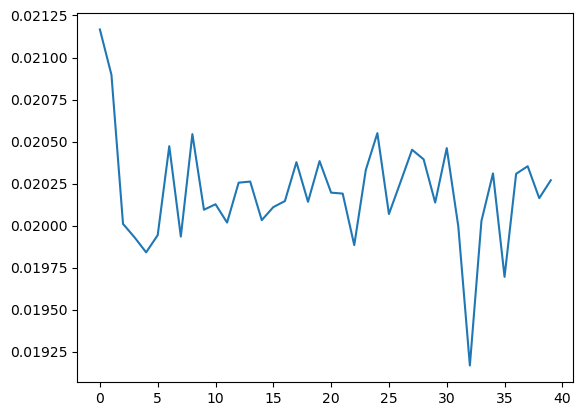

In [53]:
T = 200
f_model = MLP(1, 256, 1, T)
b_model = MLP(1, 256, 1, T)
f_optim = torch.optim.Adam(f_model.parameters())
b_optim = torch.optim.Adam(b_model.parameters())
device = "cpu"
sigma = torch.from_numpy(np.linspace(1, 0, T)*1e-2).unsqueeze(-1)
# sigma = torch.ones((T, 1))*0
# print(sigma.shape)
f_model, b_model = simple_dsb(ds, 100, 40, f_model = f_model, b_model = b_model, f_optim = f_optim, b_optim = b_optim, sigma = sigma, T = T, device = device)

In [43]:
# f_model(torch.ones((T,1,1))*2, torch.arange(0, T).unsqueeze(-1))

In [54]:
def sample(model, T, dataset, sigma, fb = "f"):
    dl = DataLoader(dataset=dataset, batch_size=len(dataset))
    for data in dl:
        # Make forward process 
        # print(data)
        x0, xT = data['x0'].to(device), data["xT"].to(device)
        xk = x0 if fb == 'f' else xT
        x_all = [xk.unsqueeze(-1)]
        time_step = [i for i in range(0, T)]
        time_step = time_step if fb == "f" else reversed(time_step)
        for i in time_step:
            # print(i)
            xk = xk + model(xk, i*torch.ones((xk.shape[0]), dtype=torch.int32)) + sigma[i]*torch.randn_like(xk)
            x_all.append(xk.unsqueeze(-1))
    x_all = torch.cat(x_all, axis = -1)
    return x_all

In [55]:
print(sigma.shape)

torch.Size([200, 1])


In [56]:
x_all = sample(model= f_model, T = T, dataset = ds, sigma = sigma.to(torch.float32), fb = "f")
x_all = x_all.detach().numpy()
print(x_all.shape)

(10000, 1, 201)


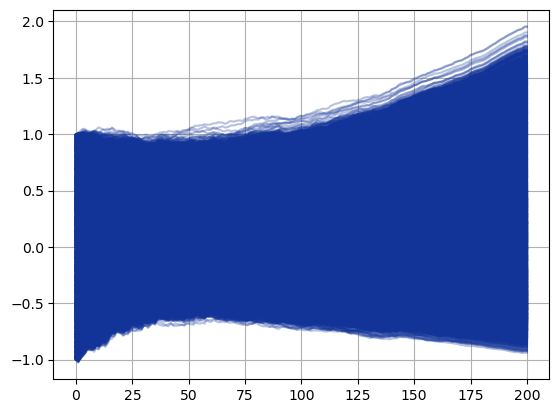

In [57]:
# plt.hist(x_all[:,:,0], bins = np.linspace(-10, 10, 100), alpha = 0.3)
# # plt.hist(x_all[:,:,1], bins = np.linspace(-10, 10, 100), alpha = 0.3)
# # plt.hist(x_all[:,:,2], bins = np.linspace(-10, 10, 100), alpha = 0.3)
# plt.hist(x_all[:,:,-1], bins = np.linspace(-10, 10, 100), alpha = 0.3)
# plt.show()
for i in range(len(x_all)):
# i = np.random.randint(0, len(x_all))
    plt.plot(x_all[i, 0, :], color = "#123499", alpha = 0.3)
plt.grid()
plt.show()

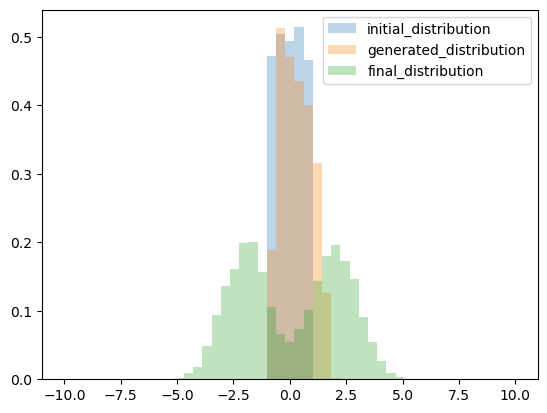

In [58]:
bins = np.linspace(-10,10,50)
plt.hist(x_all[:, 0, 0], bins = bins, alpha = 0.3, label = "initial_distribution", density = True)
plt.hist(x_all[:, 0, -1], bins = bins, alpha = 0.3, label = "generated_distribution", density = True)
plt.hist(ds.final_data.numpy(), bins = bins, alpha = 0.3, label = "final_distribution", density = True)
plt.legend()
plt.show()
# plt.hist(np.random.standard_normal((x_all.shape[0],)), bins = bins, alpha = 0.3)

In [24]:
def dsb(dataset, batch_size, epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size)
    pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
    total_loss_f = []
    total_loss_b = []
    for epoch in pbar:
        
        loss_f_all = 0
        loss_b_all = 0
        for inner_epoch in range(0, 1):
            f_model.train()
            b_model.eval()
            for data in dl:
                # Make backward process
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                px_all = torch.zeros((xT.shape[0], xT.shape[1], T))
                xk = xT
                # qx_all[:, :, 0] = xk
                with torch.no_grad():
                    for i in range(T-1, -1, -1):
                        # print(i)
                        xk = xk + b_model(xk, i*torch.ones((xk.shape[0]), dtype=torch.int32))*sigma[i] + torch.sqrt((2*sigma[i]))*torch.randn_like(xk)
                        px_all[:, :, i] = xk
                sample_t = torch.randint(high = T-2, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1))
                sample_tp1= sample_t + 1
                
                # sample_tp1[sample_tp1 == T] =T
                sample_xk = torch.gather(px_all, dim = -1, index = sample_t)
                sample_xk1 = torch.gather(px_all, dim = -1, index = sample_tp1)
                sample_t, sample_tp1 = sample_t.view(x0.shape[0]), sample_tp1.view(x0.shape[0])
                
                B_kp1_xkp1 = sample_xk1 + sigma[sample_tp1] * b_model(sample_xk1.squeeze(-1), sample_tp1)
                B_kp1 = sample_xk1 + sigma[sample_tp1] * b_model(sample_xk.squeeze(-1), sample_tp1)
                F_k = sample_xk + sigma[sample_tp1] * f_model(sample_xk.squeeze(-1), sample_t)
                f_optim.zero_grad()
                loss_f = nn.functional.mse_loss(input = F_k, target=(sample_xk.squeeze(-1) + B_kp1_xkp1 - B_kp1))
                loss_f.backward()
                # torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
                f_optim.step()
                loss_f_all += loss_f.item()
        for inner_epoch in range(0, 1):
            loss_b_all = 0
            b_model.train()
            f_model.eval()
            for data in dl:
                # Make forward process 
                # print(data)
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                qx_all = torch.zeros((x0.shape[0], x0.shape[1], T))
                # qx_all.append(xT)
                # print(x0.shape)
                # px_all.append(x0)
                xk = x0
                # px_all[:, :, 0] = xk
                for i in range(0, T):
                    xk = xk + f_model(xk, i*torch.ones((xk.shape[0]), dtype=torch.int32))*sigma[i] + torch.sqrt((2*sigma[i]))*torch.randn_like(xk)
                    qx_all[:, :, i] = xk
                
                sample_t = torch.randint(high = T-2, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1))
                sample_tp1= sample_t + 1
                
                
                # Train Backward process:
                
                sample_t = torch.randint(high = T-2, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1))
                sample_tp1= sample_t + 1
                # print(qx_all.shape, sample_t.shape)
                # sample_tp1[sample_tp1 == T] =T
                sample_xk = torch.gather(qx_all, dim = -1, index = sample_t)
                sample_xk1 = torch.gather(qx_all, dim = -1, index = sample_t)
                sample_t, sample_tp1 = sample_t.view(x0.shape[0]), sample_tp1.view(x0.shape[0])
                B_kp1 = sample_xk1 + b_model(sample_xk1.squeeze(-1), sample_tp1)*sigma[sample_tp1]
                F_k = sample_xk + sigma[sample_tp1] * f_model(sample_xk.squeeze(-1), sample_t)
                F_kp1 = sample_xk1 + sigma[sample_tp1] * f_model(sample_xk1.squeeze(-1), sample_t)
                b_optim.zero_grad()
                loss_b = nn.functional.mse_loss(input = B_kp1, target= (sample_xk1.squeeze(-1) + F_k - F_kp1))
                loss_b.backward()
                # torch.nn.utils.clip_grad_norm_(b_model.parameters(), 1)
                b_optim.step()
                loss_b_all += loss_b.item()
        
        
            total_loss_f.append(loss_f_all/len(dl))
            total_loss_b.append(loss_b_all/len(dl))
            pbar.set_postfix({"forward_loss": loss_f_all/len(dl), "backward_loss": loss_b_all/len(dl)})

    plt.plot(total_loss_f, label = "forward loss")
    plt.plot(total_loss_b, label = "backward loss")
    plt.legend()
    plt.grid()
    plt.show()
    return f_model, b_model
                
            

In [25]:
f_model = MLP(1, 128, 1)
b_model = MLP(1, 128, 1)
f_optim = torch.optim.Adam(f_model.parameters())
b_optim = torch.optim.Adam(b_model.parameters())
device = "cpu"
T = 5
dsb(ds, 100, 50, f_model = f_model, b_model = b_model, f_optim = f_optim, b_optim = b_optim, sigma = torch.ones((T,1))*1e-2, T = T, device = device)

KeyboardInterrupt: 

In [ ]:
def sample(model, T, dataset, sigma, fb = "f"):
    dl = DataLoader(dataset=dataset, batch_size=len(dataset))
    for data in dl:
        # Make forward process 
        # print(data)
        x0, xT = data['x0'].to(device), data["xT"].to(device)
        xk = x0 if fb == 'f' else xT
        x_all = [xk.unsqueeze(-1)]
        time_step = [i for i in range(0, T)]
        time_step = time_step if fb == "f" else reversed(time_step)
        for i in time_step:
            # print(i)
            xk = xk + model(xk, i*torch.ones((xk.shape[0]), dtype=torch.int32))*sigma[i] + 2*sigma[i]*torch.randn_like(xk)
            x_all.append(xk.unsqueeze(-1))
    x_all = torch.cat(x_all, axis = -1)
    return x_all
                

In [ ]:
# x_all = sample(model= f_model, T = T, dataset = ds, sigma = torch.ones((T,1))*1e-2, fb = "f")
print(T)
x_all = sample(model= f_model, T = T, dataset = ds, sigma = torch.ones((T,1))*1e-2, fb = "f")
x_all = x_all.detach().numpy()
print(x_all.shape)

In [ ]:
# x_all = x_all.detach().numpy()
plt.hist(x_all[:,:,0], bins = np.linspace(-10, 10, 100), alpha = 0.3)
plt.hist(x_all[:,:,1], bins = np.linspace(-10, 10, 100), alpha = 0.3)
plt.hist(x_all[:,:,2], bins = np.linspace(-10, 10, 100), alpha = 0.3)
plt.hist(x_all[:,:,-1], bins = np.linspace(-10, 10, 100), alpha = 0.3)
plt.show()

In [ ]:
plt.figure()
for i in range(0, 1000):
    # print(x_all[i, :, :].shape)
    plt.plot(x_all[i, 0, :], color = "#123499", alpha = 0.1)
plt.grid()
plt.show()

In [ ]:
# class Trainer:
#     def __init__(self,
#                  forward_model: nn.Module,
#                  backward_model: nn.Module,
#                  forward_optimizer: optim.Optimizer,
#                  backward_optimizer: optim.Optimizer,
#                  device: torch.device,
#                  dataset: Dataset,
#                  n_steps: int = 1000,
#                  batch_size: int = 256,
#                  T: float = 1.0,
#                  time_steps: int = 100):
#         """
#         Args:
#             forward_model (nn.Module): Model for the forward process.
#             backward_model (nn.Module): Model for the backward process.
#             forward_optimizer (optim.Optimizer): Optimizer for forward model.
#             backward_optimizer (optim.Optimizer): Optimizer for backward model.
#             device (torch.device): Device to run the training on.
#             dataset (Dataset): Dataset providing (x_initial, x_final) pairs.
#             n_steps (int): Number of training steps.
#             batch_size (int): Batch size.
#             T (float): Total time.
#             time_steps (int): Number of time discretization steps.
#         """
#         self.forward_model = forward_model.to(device)
#         self.backward_model = backward_model.to(device)
#         self.forward_optimizer = forward_optimizer
#         self.backward_optimizer = backward_optimizer
#         self.device = device
#         self.n_steps = n_steps
#         self.batch_size = batch_size
#         self.T = T
#         self.time_steps = time_steps
#         self.dt = self.T / self.time_steps
        
#         # DataLoader
#         self.loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
    
#     def train_step_forward(self, x0: torch.Tensor, t: torch.Tensor, xT: torch.Tensor) -> float:
#         """
#         Performs a single training step for the forward model.
        
#         Args:
#             x0 (torch.Tensor): Initial states.
#             t (torch.Tensor): Time scalars.
#             xT (torch.Tensor): Final states.
        
#         Returns:
#             float: Loss value.
#         """
#         self.forward_optimizer.zero_grad()
        
#         # Predict drift at (x0, t)
#         drift_forward = self.forward_model(x0, t)
        
#         # Placeholder loss: MSE between predicted drift and desired drift
#         # In practice, replace with appropriate Schrödinger bridge loss
#         desired_drift_forward = (xT - x0) / self.T
#         loss_forward = nn.MSELoss()(drift_forward, desired_drift_forward)
        
#         loss_forward.backward()
#         self.forward_optimizer.step()
        
#         return loss_forward.item()
    
#     def train_step_backward(self, xT: torch.Tensor, t: torch.Tensor, x0: torch.Tensor) -> float:
#         """
#         Performs a single training step for the backward model.
        
#         Args:
#             xT (torch.Tensor): Final states.
#             t (torch.Tensor): Time scalars.
#             x0 (torch.Tensor): Initial states.
        
#         Returns:
#             float: Loss value.
#         """
#         self.backward_optimizer.zero_grad()
        
#         # Predict drift at (xT, T - t)
#         # Note: For backward model, time is reversed
#         t_backward = self.T - t
#         drift_backward = self.backward_model(xT, t_backward)
        
#         # Placeholder loss: MSE between predicted drift and desired drift
#         desired_drift_backward = (x0 - xT) / self.T
#         loss_backward = nn.MSELoss()(drift_backward, desired_drift_backward)
        
#         loss_backward.backward()
#         self.backward_optimizer.step()
        
#         return loss_backward.item()
    
#     def train(self):
#         """
#         Runs the training loop for both forward and backward models.
#         """
#         for step in range(1, self.n_steps + 1):
#             try:
#                 x0, xT = next(self.data_iter)
#             except AttributeError:
#                 self.data_iter = iter(self.loader)
#                 x0, xT = next(self.data_iter)
            
#             x0 = x0.to(self.device)
#             xT = xT.to(self.device)
            
#             # Sample time uniformly from [0, T]
#             t = torch.rand(x0.size(0), 1).to(self.device) * self.T  # Shape: (batch_size, 1)
            
#             # Forward step
#             loss_forward = self.train_step_forward(x0, t, xT)
            
#             # Backward step
#             loss_backward = self.train_step_backward(xT, t, x0)
            
#             if step % 100 == 0 or step == 1:
#                 print(f"Step {step}/{self.n_steps} | Forward Loss: {loss_forward:.4f} | Backward Loss: {loss_backward:.4f}")
        
#         print("Training completed.")